# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# using sqlite 3 to load the data
con1 = sqlite3.connect('database.sqlite')

# Eliminating the reviews which are equal to 3
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score !=3", con1)

#Defining polarity
def polarity(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

filtered_data['Score']=filtered_data['Score'].map(polarity)
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#sorting product id in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first',inplace=False)

print(final.shape)
final.head(3)

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [6]:
(final.shape[0]/sorted_data.shape[0])*100

69.25890143662969

In [7]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


# Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [8]:
#importing the stopwords
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep

#initialising snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

#function to clean html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [10]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [57]:
from sklearn.model_selection import train_test_split
# sorting based on time
time_sorted_data = final.sort_values('Time', axis=0, ascending = True, inplace=False, kind='quicksort', na_position = 'last' )

x=time_sorted_data['CleanedText']
y=time_sorted_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS

In [58]:
count_vect = CountVectorizer(min_df=10)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)

print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254919, 12709)
the number of unique words : 12709


# Tasks

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [59]:
#Applying 10-fold CV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

#creating alpha values in range of 10(power=-3) to 10(power=3)
neighbors = []
i=0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3
    
#empty list for cv scores
cv_scores=[]

#perform 10 fold cv
for k in neighbors:
    bn=MultinomialNB(alpha=k)
    scores=cross_val_score(bn,X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs =-1)
    cv_scores.append(scores.mean())
    
#determine best alpha
optimal_alpha=neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.009.


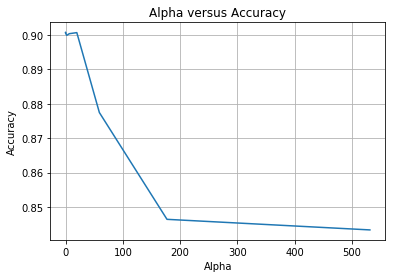


 Alpha values [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

 Accuracy values [0.90071 0.90077 0.90079 0.90079 0.90067 0.90058 0.9003  0.89991 0.90037
 0.90068 0.87746 0.84643 0.84335]


In [66]:
plt.plot(neighbors,cv_scores)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha versus Accuracy")
plt.grid()
plt.show()

print("\n Alpha values", neighbors)
print("\n Accuracy values", np.round(cv_scores,5))

In [61]:
from sklearn.metrics import accuracy_score
# NB plot for optimal alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

bn_optimal.fit(X_train_vec,Y_train)

predictions = bn_optimal.predict(X_test_vec)

acc = accuracy_score(Y_test,predictions) * 100
print('Test acc of this NB model with alpha = %.3f is %f' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_multinomial_alpha = optimal_alpha
bow_multinomial_train_acc = max(cv_scores)*100
bow_multinomial_test_acc = acc

Test acc of this NB model with alpha = 0.009 is 89.915974


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [62]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

In [68]:
class_features = bn_optimal.feature_log_prob_

# row 0 is for negative and row 1 is positive
negative_features = class_features[0]
positive_features = class_features[1]

#Getting all feature names
feature_names = count_vect.get_feature_names()

#Sorting by argsort
sorted_negative_features = np.argsort(negative_features[::-1])
sorted_positive_features = np.argsort(positive_features[::-1])

print('\033[1m  Top 10 positive features are \033[0m')
for i in list(sorted_positive_features[0:10]):
        print("%s = %f" % (feature_names[i] , positive_features[i]))

  Top 10 positive features are 
beaten = -11.356869
shipe = -13.066517
rda = -10.622099
satisfactori = -10.958553
satur = -9.239673
sandwhich = -12.162376
refresh = -7.871150
satan = -12.904077
overkil = -12.071423
long = -6.497812


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [67]:
class_features = bn_optimal.feature_log_prob_

# row 0 is for negative and row 1 is positive
negative_features = class_features[0]
positive_features = class_features[1]

#Getting all feature names
feature_names = count_vect.get_feature_names()

#Sorting by argsort
sorted_negative_features = np.argsort(negative_features[::-1])
sorted_positive_features = np.argsort(positive_features[::-1])

print('\033[1m  Top 10 negative features are \033[0m')
for i in list(sorted_negative_features[0:10]):
        print("%s = %f" % (feature_names[i] , negative_features[i]))

  Top 10 negative features are 
steam = -9.070005
weeni = -12.912620
lactaid = -19.011692
atmospher = -13.603524
kuerig = -11.356249
atroci = -11.304979
korea = -11.661461
disapprov = -12.353966
disast = -9.870237
knott = -12.912620


# Seaborn heatmap for representation of confusion matrix

TPR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.943878
FPR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.327755
TNR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.672245
FNR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.056122


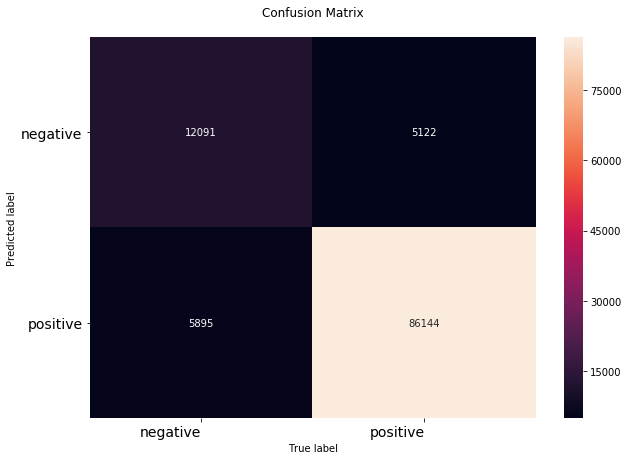

In [65]:
#Ref: Stackoverflow 
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score 
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.title("Confusion Matrix\n")
plt.show()

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [29]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)

print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254919, 12709)
the number of unique words : 12709


In [30]:
# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = MultinomialNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.081.


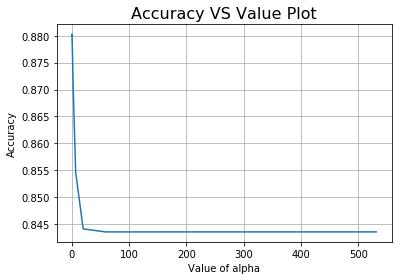



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.88013 0.88017 0.88021 0.88025 0.88029 0.87975 0.87765 0.87056 0.85458
 0.84405 0.84349 0.84349 0.84349]


In [42]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [32]:
#MNB with optimal alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_multinomial_alpha = optimal_alpha
tfidf_multinomial_train_acc = max(cv_scores)*100
tfidf_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.081 is 87.881229%


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [33]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

In [71]:
class_features = bn_optimal.feature_log_prob_

# row 0 is for negative and row 1 is positive
negative_features = class_features[0]
positive_features = class_features[1]

#Getting all feature names
feature_names = count_vect.get_feature_names()

#Sorting by argsort
sorted_negative_features = np.argsort(negative_features[::-1])
sorted_positive_features = np.argsort(positive_features[::-1])

print('\033[1m  Top 10 positive features are \033[0m')
for i in list(sorted_positive_features[0:10]):
        print("%s = %f" % (feature_names[i] , positive_features[i]))

  Top 10 positive features are 
beaten = -11.356869
shipe = -13.066517
rda = -10.622099
satisfactori = -10.958553
satur = -9.239673
sandwhich = -12.162376
refresh = -7.871150
satan = -12.904077
overkil = -12.071423
long = -6.497812


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [69]:
class_features = bn_optimal.feature_log_prob_

# row 0 is for negative and row 1 is positive
negative_features = class_features[0]
positive_features = class_features[1]

#Getting all feature names
feature_names = count_vect.get_feature_names()

#Sorting by argsort
sorted_negative_features = np.argsort(negative_features[::-1])
sorted_positive_features = np.argsort(positive_features[::-1])

print('\033[1m  Top 10 negative features are \033[0m')
for i in list(sorted_negative_features[0:10]):
        print("%s = %f" % (feature_names[i] , negative_features[i]))

  Top 10 negative features are 
steam = -9.070005
weeni = -12.912620
lactaid = -19.011692
atmospher = -13.603524
kuerig = -11.356249
atroci = -11.304979
korea = -11.661461
disapprov = -12.353966
disast = -9.870237
knott = -12.912620


TPR of the Multinomial naive Bayes classifier for alpha = 0.081 is :  0.877965
FPR of the Multinomial naive Bayes classifier for alpha = 0.081 is :  0.103572
TNR of the Multinomial naive Bayes classifier for alpha = 0.081 is :  0.896428
FNR of the Multinomial naive Bayes classifier for alpha = 0.081 is :  0.122035


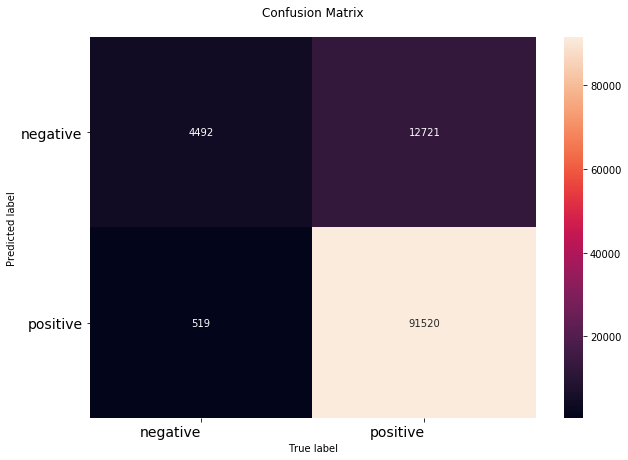

In [55]:
#Ref: Stackoverflow 
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score 
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.title("Confusion Matrix\n")
plt.show()

# [6] Conclusions

In [39]:
# Please compare all your models using Prettytable library
#Ref: http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
import random

x = PrettyTable()
numbering = [1,2]
names = ["Multinomial NB for BOW", "Multinomial NB for Tfidf"]
optimal_alpha = [bow_multinomial_alpha,tfidf_multinomial_alpha]
train_acc = [bow_multinomial_train_acc, tfidf_multinomial_train_acc]
test_acc = [bow_multinomial_test_acc, tfidf_multinomial_test_acc]

# Adding columns
x.add_column("S.NO.",numbering)
x.add_column("MODEL",names)
x.add_column("Best Alpha",optimal_alpha)
x.add_column("Training Accuracy",train_acc)
x.add_column("Test Accuracy",test_acc)

# Printing the Table
print(x)

+-------+--------------------------+------------+-------------------+-------------------+
| S.NO. |          MODEL           | Best Alpha | Training Accuracy |   Test Accuracy   |
+-------+--------------------------+------------+-------------------+-------------------+
|   1   |  Multinomial NB for BOW  |   0.009    | 90.07920206759049 | 89.91597407827774 |
|   2   | Multinomial NB for Tfidf |   0.081    | 88.02874746506195 | 87.88122871892506 |
+-------+--------------------------+------------+-------------------+-------------------+
